<a href="https://colab.research.google.com/github/BenjaminGuerreroLewin/landslide_inventory/blob/main/Landslides_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive

In [2]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Packages

In [3]:
from osgeo import gdal
import os
import glob
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from scipy.ndimage.filters import generic_filter
from scipy.stats import mode

### Preparing the dataset: Opening the images


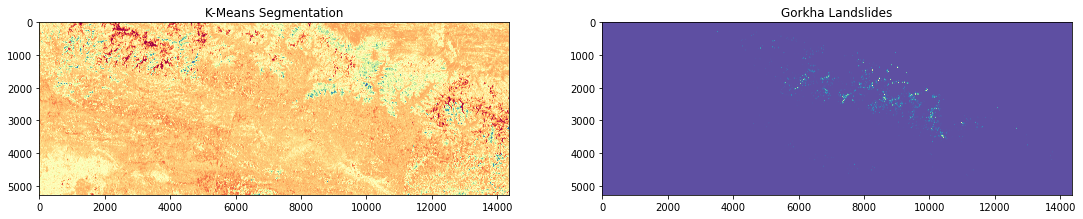

In [5]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()  


# Read in our image and ROI image
#img_ds = gdal.Open('/content/drive/MyDrive/EnvDatSci_FinalProject/NDVI_chicamocha.tif', gdal.GA_ReadOnly)
img_ds = gdal.Open('/content/drive/MyDrive/EnvDatSci_FinalProject/K-Means_Gorkha.tif', gdal.GA_ReadOnly)
#roi_ds = gdal.Open('/content/drive/MyDrive/EnvDatSci_FinalProject/training_land.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('/content/drive/MyDrive/EnvDatSci_FinalProject/cosito.tif', gdal.GA_ReadOnly)

gt = roi_ds.GetGeoTransform()
lt = img_ds.GetGeoTransform()

SmlMaxX = gt[0] + (gt[1] * roi_ds.RasterXSize)
SmlMinY = gt[3] + (gt[5] * roi_ds.RasterYSize)
Xoff = int((gt[0] - lt[0])/lt[1]) # cols to skip
Yoff = int((gt[3] - lt[3])/lt[5]) # rows to skip
Cols = int((SmlMaxX - gt[0])/lt[1])
Rows = int((SmlMinY - gt[3])/lt[5])

band = img_ds.GetRasterBand(1)
data = img_ds.ReadAsArray(Xoff,Yoff,Cols,Rows) # read the larger raster

img = np.zeros((data.shape[0], data.shape[1], 1),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
img[:, :, 0] = data
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Spectral)
plt.title('K-Means Segmentation')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Gorkha Landslides')

fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)


###Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the ROI with the land cover labels (our Y labeled data), we need to pair them up in NumPy arrays so we may feed them to Random Forest:

In [6]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))


We have 75696250 samples
The training data include 2 classes: [1 2]
Our X matrix is sized: (75696250, 1)
Our y array is sized: (75696250,)


### Splitting reference data in training (30%) and testing dataset (70%)
random state = 1 $→$ same random selection (ensures reproductivity of results)



default: shuffle = True $→$ data is shuffled before splitting

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, train_size=0.3,
                        random_state=1,stratify=y)
#shapes of splittet datasets
print("Splitting of reference data in training and testing dataset (30:70):")
print("Training dataset (Shape): X: {x}, y:{y}".format(x=X_train.shape, y=y_train.shape))
print("Testing dataset (Shape): X: {x}, y:{y}".format(x=X_test.shape,y=y_test.shape))

Splitting of reference data in training and testing dataset (60:40):
Training dataset (Shape): X: (22708875, 1), y:(22708875,)
Testing dataset (Shape): X: (52987375, 1), y:(52987375,)


### Training the Random Forest
Now that we have our X matrix of feature inputs (the NDVI band) and our y array (the labels), we can train our model.

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

### Random Forest diagnostics
With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [9]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))


Our OOB prediction of accuracy is: 99.89288328902246%


Preparation of prediction (classification) of the raster scene: Reshaping of img array in two dimensions (nrow * ncol, nband)



In [10]:
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img[:, :, :].reshape(new_shape)
print("Reshaping of X Arrays in two dimensions: {o} -> {n}".format(o=img.shape,
                                          n=img_as_array.shape))

Reshaping of X Arrays in two dimensions: (5275, 14350, 1) -> (75696250, 1)


Classification of each pixel and reshaping in original raster shape (nrow, ncol).

In [11]:
class_prediction = rf.predict(img_as_array)
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print("Shape of final classification: {o}". format(o=class_prediction.shape))

Shape of final classification: (5275, 14350)


### Analysis of the classification
Evaluation of the significance of each band for the classification: Out-of-band score (oob)
The OOB score of each band can be interpreted as percent (the score of all bands add up to 1).

In [13]:
print("The OOB score for accuracy is: {oob}%".format(oob=rf.oob_score_ * 100))


The OOB score for accuracy is: 99.89288328902246%


### Accuracy Assessment

In [14]:
#Classification with testing dataset (X_test, y_test)
y_TestPredicted = rf.predict(X_test)
#Result accuracy assessment 
print("Accuracy score:", accuracy_score(y_test,y_TestPredicted))
print("Confusion matrix:\n", confusion_matrix(y_test,y_TestPredicted))
print("Classification report:\n", classification_report(y_test,y_TestPredicted))

Accuracy score: 0.9989288203086113
Confusion matrix:
 [[       0    56759]
 [       0 52930616]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00     56759
           2       1.00      1.00      1.00  52930616

    accuracy                           1.00  52987375
   macro avg       0.50      0.50      0.50  52987375
weighted avg       1.00      1.00      1.00  52987375



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Postprocessing - Reduction of the Salt-and-Pepper-Effect
The Salt-and-Pepper-Effect results from the pixel based classification, which can be reduced by applying a filter, such as a modal filter in a 3x3 moving window. This filter assigns the most frequent, surrounding pixel value to the central pixel. The respective function had to be defined (see "Function Definitions"). The smoothing effect of the filter highlights trends of the pixel based classification, which is why the certain loss of information can be accepted.

In [15]:
def modal_filter(values):
    '''
    Function for calculating the modal filter in moving window
    Assigns the most frequent, surrounding pixel value to the central pixel
    The smoothing effect highlights trends of the pixel based classification; certain loss of information

    Parameter: array (pixel values in moving window)
    Returns: float (single pixel value = most frequent value in moving window)
    '''
    raster_mode = mode(values,axis=None,nan_policy ="omit") 

    return raster_mode[0]

class_prediction_filtered = generic_filter(class_prediction,function=modal_filter,size=3)


### Visualization with Matplotlib

In [19]:
classes = {
    1 : ("Landslide", "#964b00"),
    2 : ("Bare Area","#ffffff"),
    }

classes_colors = []
classes_labels = []

for key in classes:
    values = classes.get(key)
    label = values[0]
    color = values[1]

    classes_labels.append(label)
    classes_colors.append(color)

n_classes = class_prediction.max()

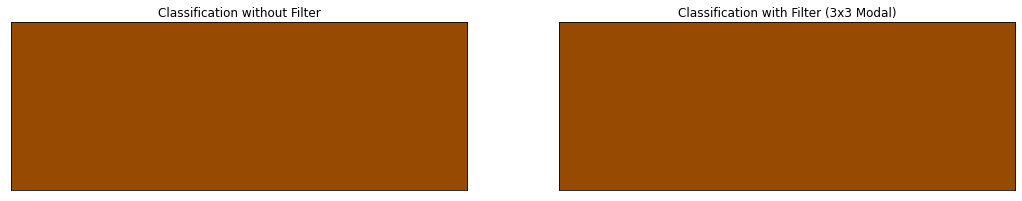

In [20]:
fig = plt.figure(figsize=(18,12))
cmap = plt.matplotlib.colors.ListedColormap(classes_colors, N=n_classes) #colormap
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)  
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.imshow(class_prediction,cmap=cmap)
ax2.imshow(class_prediction_filtered,cmap=cmap)
ax1.title.set_text("Classification without Filter")
ax2.title.set_text("Classification with Filter (3x3 Modal)")
plt.show()